In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
#from ..utils import load_state_dict_from_url

from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['r3d_18', 'mc3_18', 'r2plus1d_18']

model_urls = {
    'r3d_18': 'https://download.pytorch.org/models/r3d_18-b3b3357e.pth',
    'mc3_18': 'https://download.pytorch.org/models/mc3_18-a90a0ba3.pth',
    'r2plus1d_18': 'https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth',
}


class Conv3DSimple(nn.Conv3d):
    def __init__(self,
                 in_planes,
                 out_planes,
                 midplanes=None,
                 stride=1,
                 padding=1):

        super(Conv3DSimple, self).__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(3, 3, 3),
            stride=stride,
            padding=padding,
            bias=False)

    @staticmethod
    def get_downsample_stride(stride):
        return stride, stride, stride


class Conv2Plus1D(nn.Sequential):

    def __init__(self,
                 in_planes,
                 out_planes,
                 midplanes,
                 stride=1,
                 padding=1):
        super(Conv2Plus1D, self).__init__(
            nn.Conv3d(in_planes, midplanes, kernel_size=(1, 3, 3),
                      stride=(1, stride, stride), padding=(0, padding, padding),
                      bias=False),
            nn.BatchNorm3d(midplanes),
            nn.ReLU(inplace=True),
            nn.Conv3d(midplanes, out_planes, kernel_size=(3, 1, 1),
                      stride=(stride, 1, 1), padding=(padding, 0, 0),
                      bias=False))

    @staticmethod
    def get_downsample_stride(stride):
        return stride, stride, stride


class Conv3DNoTemporal(nn.Conv3d):

    def __init__(self,
                 in_planes,
                 out_planes,
                 midplanes=None,
                 stride=1,
                 padding=1):

        super(Conv3DNoTemporal, self).__init__(
            in_channels=in_planes,
            out_channels=out_planes,
            kernel_size=(1, 3, 3),
            stride=(1, stride, stride),
            padding=(0, padding, padding),
            bias=False)

    @staticmethod
    def get_downsample_stride(stride):
        return 1, stride, stride


class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, inplanes, planes, conv_builder, stride=1, downsample=None):
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
            conv_builder(inplanes, planes, midplanes, stride),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            conv_builder(planes, planes, midplanes),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, conv_builder, stride=1, downsample=None):

        super(Bottleneck, self).__init__()
        midplanes = (inplanes * planes * 3 * 3 * 3) // (inplanes * 3 * 3 + 3 * planes)

        # 1x1x1
        self.conv1 = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=1, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        # Second kernel
        self.conv2 = nn.Sequential(
            conv_builder(planes, planes, midplanes, stride),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )

        # 1x1x1
        self.conv3 = nn.Sequential(
            nn.Conv3d(planes, planes * self.expansion, kernel_size=1, bias=False),
            nn.BatchNorm3d(planes * self.expansion)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class BasicStem(nn.Sequential):
    """The default conv-batchnorm-relu stem
    """
    def __init__(self):
        super(BasicStem, self).__init__(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2),
                      padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True))


class R2Plus1dStem(nn.Sequential):
    """R(2+1)D stem is different than the default one as it uses separated 3D convolution
    """
    def __init__(self):
        super(R2Plus1dStem, self).__init__(
            nn.Conv3d(3, 45, kernel_size=(1, 7, 7),
                      stride=(1, 2, 2), padding=(0, 3, 3),
                      bias=False),
            nn.BatchNorm3d(45),
            nn.ReLU(inplace=True),
            nn.Conv3d(45, 64, kernel_size=(3, 1, 1),
                      stride=(1, 1, 1), padding=(1, 0, 0),
                      bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True))


class VideoResNet(nn.Module):

    def __init__(self, block, conv_makers, layers,
                 stem, num_classes=400,
                 zero_init_residual=False):
        """Generic resnet video generator.

        Args:
            block (nn.Module): resnet building block
            conv_makers (list(functions)): generator function for each layer
            layers (List[int]): number of blocks per layer
            stem (nn.Module, optional): Resnet stem, if None, defaults to conv-bn-relu. Defaults to None.
            num_classes (int, optional): Dimension of the final FC layer. Defaults to 400.
            zero_init_residual (bool, optional): Zero init bottleneck residual BN. Defaults to False.
        """
        super(VideoResNet, self).__init__()
        self.inplanes = 64

        self.stem = stem()

        self.layer1 = self._make_layer(block, conv_makers[0], 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, conv_makers[1], 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, conv_makers[2], 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, conv_makers[3], 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # init weights
        self._initialize_weights()

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def forward(self, x):
        x = self.stem(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # Flatten the layer to fc
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, conv_builder, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            ds_stride = conv_builder.get_downsample_stride(stride)
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=ds_stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, conv_builder, stride, downsample))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, conv_builder))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def _video_resnet(arch, pretrained=False, progress=True, **kwargs):
    model = VideoResNet(**kwargs)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def r3d_18(pretrained=False, progress=True, **kwargs):
    """Construct 18 layer Resnet3D model as in
    https://arxiv.org/abs/1711.11248

    Args:
        pretrained (bool): If True, returns a model pre-trained on Kinetics-400
        progress (bool): If True, displays a progress bar of the download to stderr

    Returns:
        nn.Module: R3D-18 network
    """

    return _video_resnet('r3d_18',
                         pretrained, progress,
                         block=BasicBlock,
                         conv_makers=[Conv3DSimple] * 4,
                         layers=[2, 2, 2, 2],
                         stem=BasicStem, **kwargs)


def mc3_18(pretrained=False, progress=True, **kwargs):
    """Constructor for 18 layer Mixed Convolution network as in
    https://arxiv.org/abs/1711.11248

    Args:
        pretrained (bool): If True, returns a model pre-trained on Kinetics-400
        progress (bool): If True, displays a progress bar of the download to stderr

    Returns:
        nn.Module: MC3 Network definition
    """
    return _video_resnet('mc3_18',
                         pretrained, progress,
                         block=BasicBlock,
                         conv_makers=[Conv3DSimple] + [Conv3DNoTemporal] * 3,
                         layers=[2, 2, 2, 2],
                         stem=BasicStem, **kwargs)


def r2plus1d_18(pretrained=False, progress=True, **kwargs):
    """Constructor for the 18 layer deep R(2+1)D network as in
    https://arxiv.org/abs/1711.11248

    Args:
        pretrained (bool): If True, returns a model pre-trained on Kinetics-400
        progress (bool): If True, displays a progress bar of the download to stderr

    Returns:
        nn.Module: R(2+1)D-18 network
    """
    return _video_resnet('r2plus1d_18',
                         pretrained, progress,
                         block=BasicBlock,
                         conv_makers=[Conv2Plus1D] * 4,
                         layers=[2, 2, 2, 2],
                         stem=R2Plus1dStem, **kwargs)

In [4]:
#모델 불러오기 예시
mc3_18_model = mc3_18(pretrained=True)

# Freeze all the layers in the beginning
for param in mc3_18_model.parameters():
    param.requires_grad = False

# Modify the last layer for transfer learning
num_features = mc3_18_model.fc.in_features
mc3_18_model.fc = nn.Linear(num_features, 3)  # num_classes is the number of classes in your dataset

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = mc3_18_model.to(device)

Downloading: "https://download.pytorch.org/models/mc3_18-a90a0ba3.pth" to /root/.cache/torch/hub/checkpoints/mc3_18-a90a0ba3.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 214MB/s]


In [5]:
from torchsummary import summary
summary(model, input_size=(3, 113, 137, 113))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 64, 113, 69, 57]          28,224
       BatchNorm3d-2      [-1, 64, 113, 69, 57]             128
              ReLU-3      [-1, 64, 113, 69, 57]               0
      Conv3DSimple-4      [-1, 64, 113, 69, 57]         110,592
       BatchNorm3d-5      [-1, 64, 113, 69, 57]             128
              ReLU-6      [-1, 64, 113, 69, 57]               0
      Conv3DSimple-7      [-1, 64, 113, 69, 57]         110,592
       BatchNorm3d-8      [-1, 64, 113, 69, 57]             128
              ReLU-9      [-1, 64, 113, 69, 57]               0
       BasicBlock-10      [-1, 64, 113, 69, 57]               0
     Conv3DSimple-11      [-1, 64, 113, 69, 57]         110,592
      BatchNorm3d-12      [-1, 64, 113, 69, 57]             128
             ReLU-13      [-1, 64, 113, 69, 57]               0
     Conv3DSimple-14      [-1, 64, 113,

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import nibabel as nib
import os

# Custom dataset class for 3D MRI data
class MRIDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.filepaths = []

        for class_name in self.classes:
            class_path = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                self.filepaths.append((filepath, self.classes.index(class_name)))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath, label = self.filepaths[idx]
        img = nib.load(filepath).get_fdata()

        # Apply any transformations here if needed
        if self.transform:
            img = self.transform(img)
        #print(img.shape)
        # Convert to RGB by stacking along the channel dimension
        img_rgb = torch.stack([torch.Tensor(img)] * 3, dim=0)  # Assuming img is a 3D tensor

        return img_rgb, torch.tensor(label)

# Define your data directory and other parameters
data_dir = '/content/drive/MyDrive/2023 의학영상처리/task_2'

In [7]:
!cp "/content/drive/MyDrive/2023 의학영상처리/data_split.py" /content/
from data_split import split_dataset
!python /content/data_split.py

In [8]:
batch_size = 8
validation_split = 0.2
test_split = 0.1


# Create an instance of the custom dataset
dataset = MRIDataset(data_dir)

for i, class_name in enumerate(dataset.classes):
    print(f"Class: {class_name}, Label: {i}")

# Calculate the sizes of train, validation, and test sets
num_samples = len(dataset)
num_validation = int(validation_split * num_samples)
num_test = int(test_split * num_samples)
num_train = num_samples - num_validation - num_test

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_validation, num_test])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print the shapes of the batches
for batch in train_loader:
    features, labels = batch
    print("Feature batch shape:", features.shape)
    print("Labels batch shape:", labels.shape)
    break  # Print only the first batch for brevity

Class: AD, Label: 0
Class: CN, Label: 1
Class: MCI, Label: 2
Feature batch shape: torch.Size([8, 3, 113, 137, 113])
Labels batch shape: torch.Size([8])


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 20

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20, Training Loss: 1.1290, Training Accuracy: 0.4048, Validation Loss: 1.1206, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/20, Training Loss: 1.1277, Training Accuracy: 0.3571, Validation Loss: 1.1442, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/20, Training Loss: 1.1082, Training Accuracy: 0.3333, Validation Loss: 1.1193, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/20, Training Loss: 1.0912, Training Accuracy: 0.3571, Validation Loss: 1.1511, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/20, Training Loss: 1.1312, Training Accuracy: 0.3571, Validation Loss: 1.1492, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/20, Training Loss: 1.0995, Training Accuracy: 0.3810, Validation Loss: 1.1794, Validation Accuracy: 0.2500, Precision: 0.0625, Recall: 0.2500, F1 Score: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/20, Training Loss: 1.1259, Training Accuracy: 0.3333, Validation Loss: 1.1299, Validation Accuracy: 0.2500, Precision: 0.0625, Recall: 0.2500, F1 Score: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/20, Training Loss: 1.0850, Training Accuracy: 0.3333, Validation Loss: 1.0878, Validation Accuracy: 0.4167, Precision: 0.1736, Recall: 0.4167, F1 Score: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/20, Training Loss: 1.2267, Training Accuracy: 0.3333, Validation Loss: 1.1072, Validation Accuracy: 0.4167, Precision: 0.1736, Recall: 0.4167, F1 Score: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/20, Training Loss: 1.1236, Training Accuracy: 0.3095, Validation Loss: 1.1842, Validation Accuracy: 0.2500, Precision: 0.0625, Recall: 0.2500, F1 Score: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/20, Training Loss: 1.1976, Training Accuracy: 0.2857, Validation Loss: 1.1725, Validation Accuracy: 0.3333, Precision: 0.1806, Recall: 0.3333, F1 Score: 0.2333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/20, Training Loss: 1.1124, Training Accuracy: 0.3571, Validation Loss: 1.0839, Validation Accuracy: 0.4167, Precision: 0.1736, Recall: 0.4167, F1 Score: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/20, Training Loss: 1.1434, Training Accuracy: 0.3333, Validation Loss: 1.1289, Validation Accuracy: 0.4167, Precision: 0.1736, Recall: 0.4167, F1 Score: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/20, Training Loss: 1.1433, Training Accuracy: 0.3333, Validation Loss: 1.1110, Validation Accuracy: 0.5000, Precision: 0.3611, Recall: 0.5000, F1 Score: 0.4141


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/20, Training Loss: 1.1165, Training Accuracy: 0.2857, Validation Loss: 1.1140, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/20, Training Loss: 1.1437, Training Accuracy: 0.3333, Validation Loss: 1.1348, Validation Accuracy: 0.2500, Precision: 0.0625, Recall: 0.2500, F1 Score: 0.1000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/20, Training Loss: 1.1122, Training Accuracy: 0.3571, Validation Loss: 1.0911, Validation Accuracy: 0.4167, Precision: 0.1736, Recall: 0.4167, F1 Score: 0.2451


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/20, Training Loss: 1.0947, Training Accuracy: 0.3333, Validation Loss: 1.0855, Validation Accuracy: 0.4167, Precision: 0.3095, Recall: 0.4167, F1 Score: 0.3485


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/20, Training Loss: 1.0767, Training Accuracy: 0.4048, Validation Loss: 1.1322, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/20, Training Loss: 1.1474, Training Accuracy: 0.3571, Validation Loss: 1.1068, Validation Accuracy: 0.3333, Precision: 0.1111, Recall: 0.3333, F1 Score: 0.1667


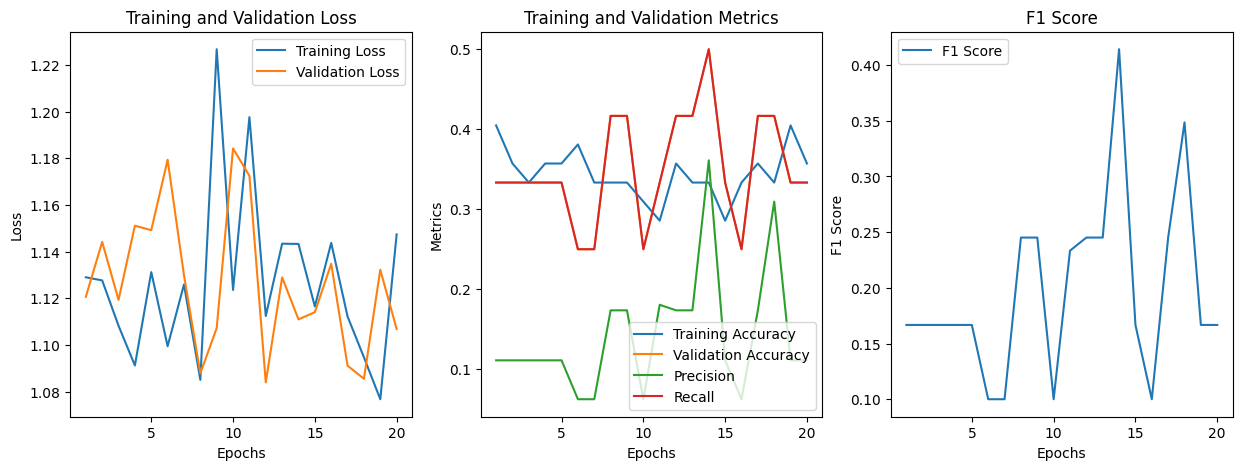

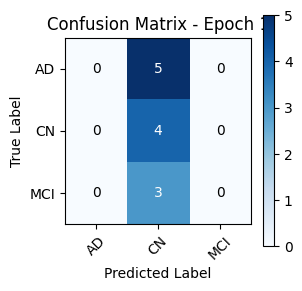

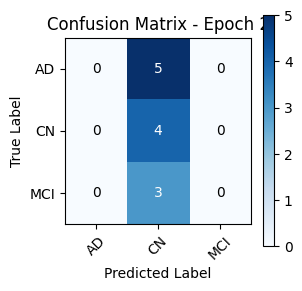

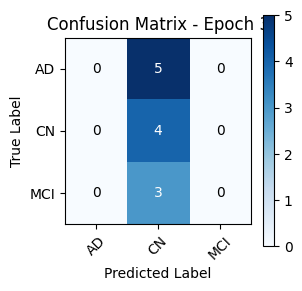

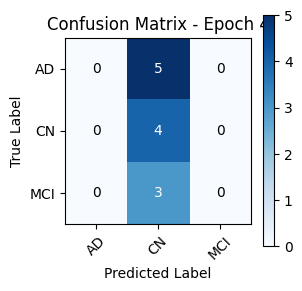

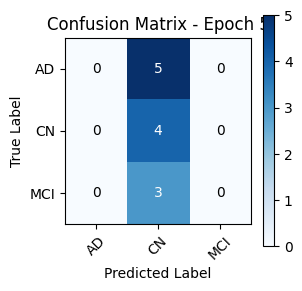

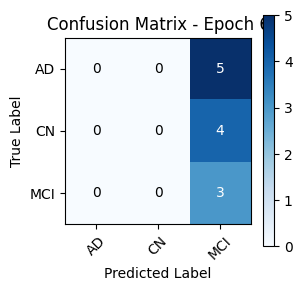

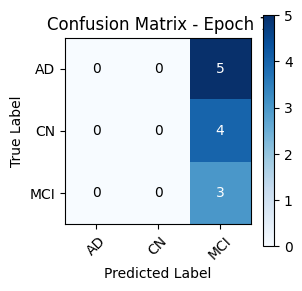

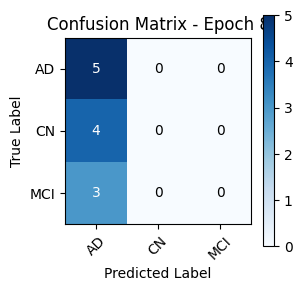

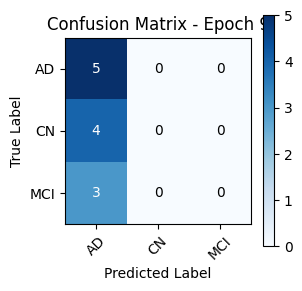

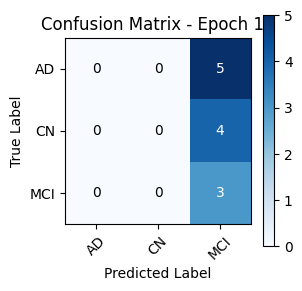

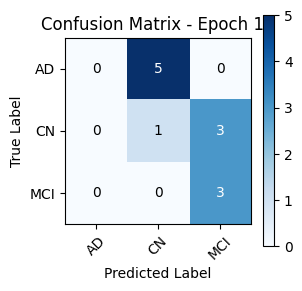

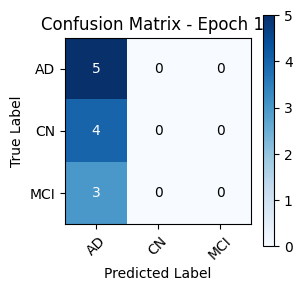

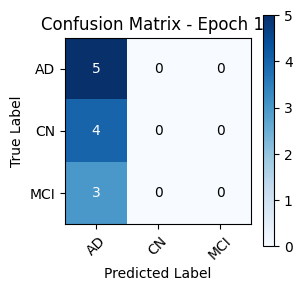

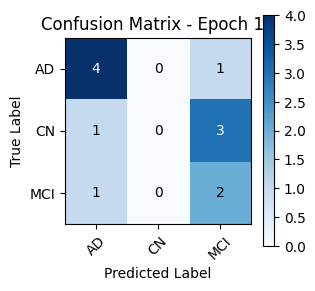

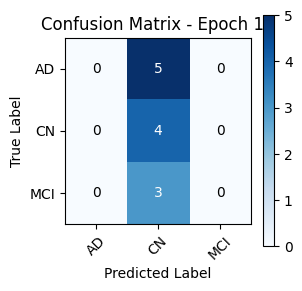

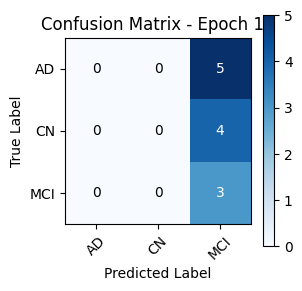

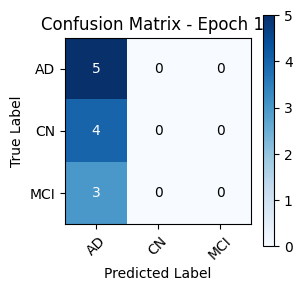

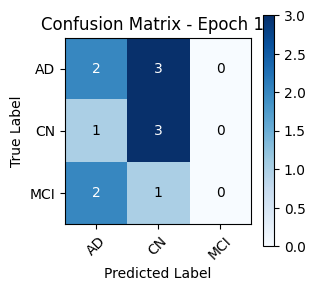

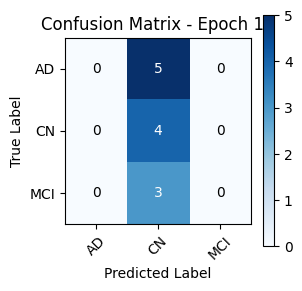

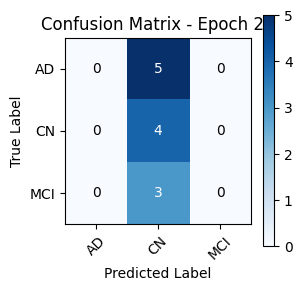

In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy, loss, precision, and recall
    train_accuracy = correct_train / total_train
    train_loss = total_train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_predicted = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation accuracy, loss, precision, recall, F1 score, and confusion matrix
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Calculate precision, recall, F1 score using scikit-learn functions
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    f1 = f1_score(all_labels, all_predicted, average='weighted')

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    conf_matrices.append(conf_matrix)

    # Print and plot results
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}, '
          f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Plotting the results
epochs_list = list(range(1, num_epochs + 1))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_list, train_accuracies, label='Training Accuracy')
plt.plot(epochs_list, val_accuracies, label='Validation Accuracy')
plt.plot(epochs_list, precision_scores, label='Precision')
plt.plot(epochs_list, recall_scores, label='Recall')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_list, f1_scores, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# 혼동 행렬 시각화
classes = dataset.classes

for epoch, conf_matrix in enumerate(conf_matrices):
    plt.figure(figsize=(len(classes), len(classes)))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # 클래스 이름 추가
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 수치 추가
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    plt.show()

Accuracy: 0.1667
Precision: 0.0278
Recall: 0.1667
F1 Score: 0.0476
Average Test Loss: 1.1897


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


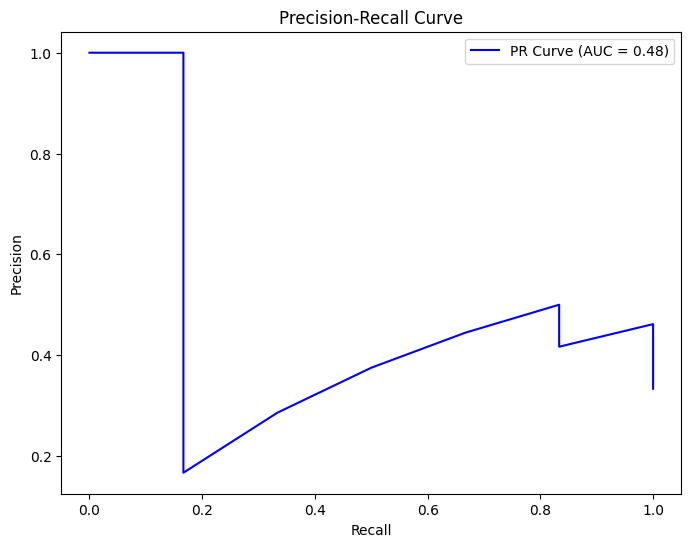

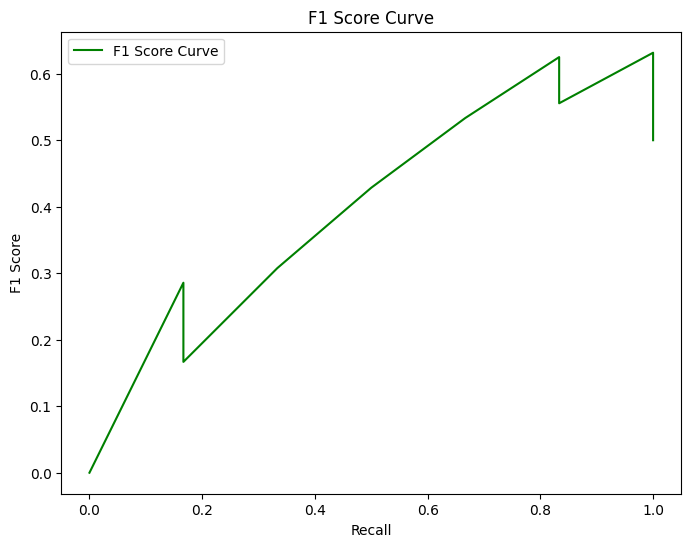

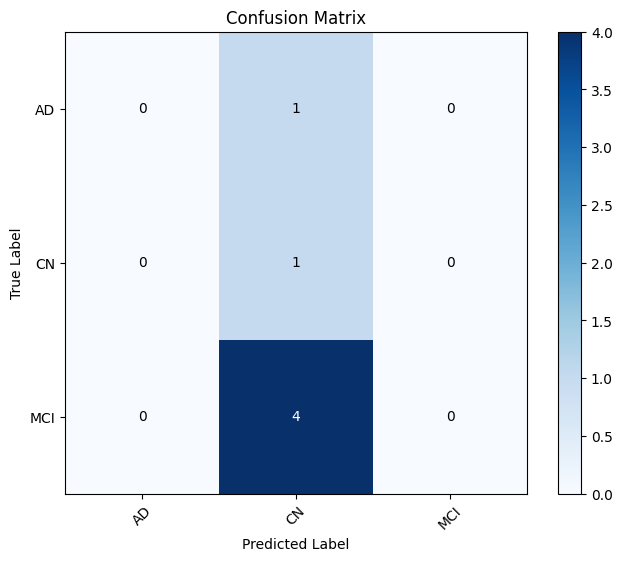

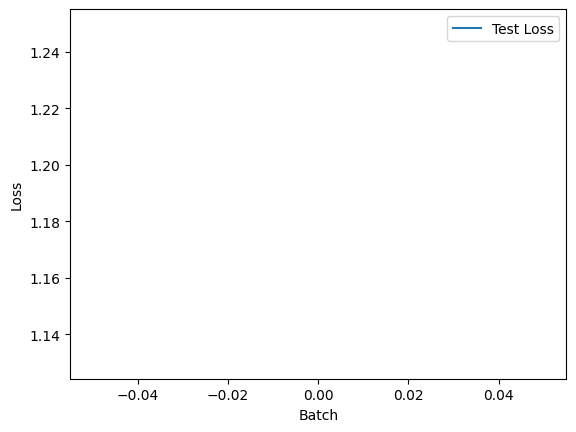

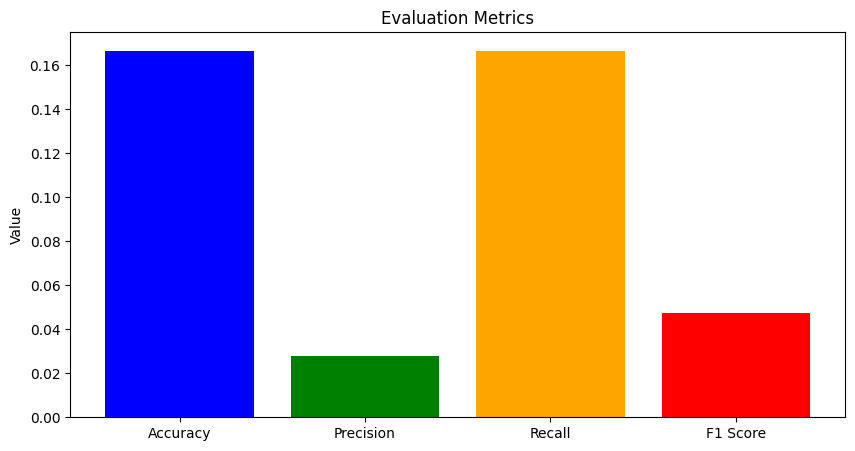

In [11]:
# 모델을 평가 모드로 전환
model.eval()

# 평가를 위한 변수 초기화
all_targets = []
all_predictions = []
all_test_losses = []
all_probs = []
batch_losses = []

# 데이터셋 전체에 대한 예측 수행
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        test_loss = criterion(outputs, targets)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        all_test_losses.append(test_loss.item())
        batch_losses.append(test_loss.item())
        all_targets.extend(targets.cpu().numpy())  # CPU로 옮겨서 numpy() 호출
        all_predictions.extend(predictions.cpu().numpy())  # CPU로 옮겨서 numpy() 호출
        all_probs.extend(probs.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(all_targets, all_predictions)
precision = precision_score(all_targets, all_predictions, average='weighted')
recall = recall_score(all_targets, all_predictions, average='weighted')
f1 = f1_score(all_targets, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_targets, all_predictions)
average_test_loss = sum(all_test_losses) / len(all_test_losses)

# Convert target labels to one-hot encoding
binarized_targets = label_binarize(all_targets, classes=np.unique(all_targets))

# Calculate precision-recall curve
precision_values, recall_values, _ = precision_recall_curve(binarized_targets.ravel(), np.array(all_probs).ravel())
area_under_curve = auc(recall_values, precision_values)

# 평가 지표 출력
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Average Test Loss: {average_test_loss:.4f}')

# Visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, color='blue', label=f'PR Curve (AUC = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Calculate F1 score curve
f1_curve_values = 2 * (precision_values * recall_values) / (precision_values + recall_values)

# Visualize F1 score curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, f1_curve_values, color='green', label='F1 Score Curve')
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.show()

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 클래스 이름 추가
classes = dataset.classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# 수치 추가
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

# Loss 그래프 시각화
plt.plot(batch_losses, label='Test Loss')  # Updated: plot loss for each batch
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy, Precision, Recall, F1 Score 그래프 시각화
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Value')
plt.title('Evaluation Metrics')
plt.show()

In [12]:
PATH = '/content/drive/MyDrive/task2_mc3_18.pth'
torch.save(model.state_dict(), PATH)